# Test the photometry functionality and compare output...

### Get background using sigma clipped stats

Mean: 2831.8837890625, Median: 2831.155517578125, SD: 61.87967300415039


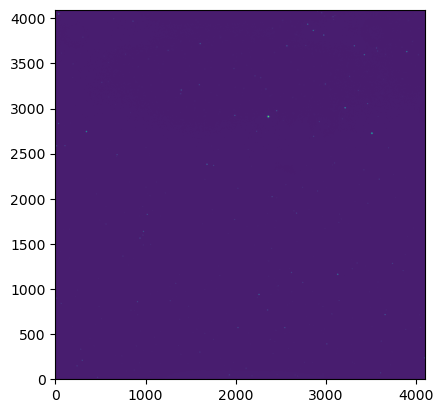

In [1]:
import photutils as pht
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt

data=fits.getdata('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1.fit')
## here we can show some statistics about the sky
plt.imshow(data, origin='lower')
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(f"Mean: {mean}, Median: {median}, SD: {std}")

### get the background mask/map

/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


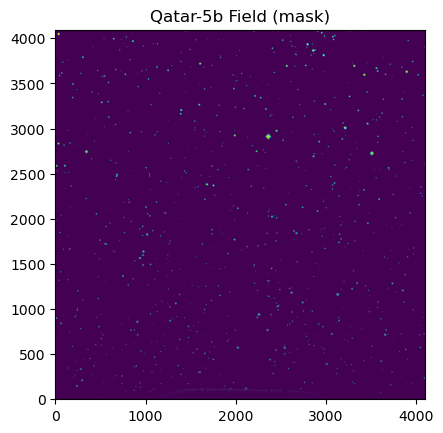

In [2]:
from photutils.segmentation import detect_sources
import matplotlib.pyplot as plt

segm = detect_sources(data-mean, 3*std, npixels=5)
#flipping here causes no issue, why does flipping data cause problems? should we flip flat/bias...
plt.imshow(segm.data, origin = 'lower')

plt.title("Qatar-5b Field (mask)")
plt.savefig("field_mask_plot.png")

### Convert the segmentation image to a numpy array, this can serve as mask, 

Text(0.5, 1.0, 'Boolean Sky Mask')

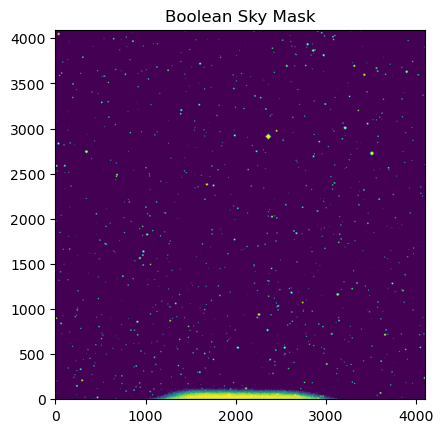

In [3]:
bool_array = segm.data != 0 
plt.imshow(bool_array, origin='lower')
plt.title('Boolean Sky Mask')

In [4]:
from astropy.stats import SigmaClip
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = pht.background.SExtractorBackground()
bkg = pht.background.Background2D(data, (64, 64), mask=bool_array,filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

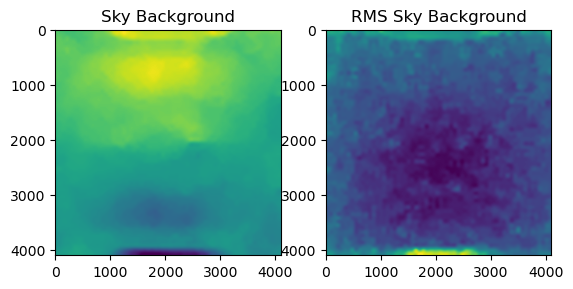

In [5]:
fig, axs = plt.subplots(1,2)
axs[0].set_title('Sky Background')
axs[0].imshow(bkg.background)
axs[1].set_title('RMS Sky Background')
axs[1].imshow(bkg.background_rms)

In [6]:
from photutils.detection import IRAFStarFinder

threshold_multiplier=15.0
daofind = IRAFStarFinder(fwhm=3.0, threshold=threshold_multiplier*bkg.background_rms_median,exclude_border=True, sharplo=0.5, sharphi=2.0, roundlo=0.0, roundhi=0.7)
sources = daofind(data - bkg.background_median)
print(sources)

 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  471.9253869850101 ...   46238.5556640625 -11.662510649337603
  2  2686.790425508937 ... 22075.305419921875 -10.859766802285302
  3 2970.7315842965827 ...     4404.544921875  -9.109752609266218
  4 2180.7980010276983 ...  15182.02001953125   -10.4533238994142
  5 3566.1533392700994 ...  5005.826904296875  -9.248689570327727
  6  2658.886895206944 ...     16681.27734375 -10.555573257556198
  7 1930.0162173931808 ...   63153.6455078125  -12.00099606253441
  8  2460.025365666135 ...  10826.87353515625 -10.086257659925073
  9  3604.710431795118 ...   71923.8271484375  -12.14218197160526
 10 2021.4186139623425 ...    3058.7646484375  -8.713865155507577
...                ... ...                ...                 ...
341 3077.8002313354714 ...   65999.2548828125 -12.048847581199006
342    2983.7346676783 ...    15157.005859375 -10.451533546251534
343  3098.

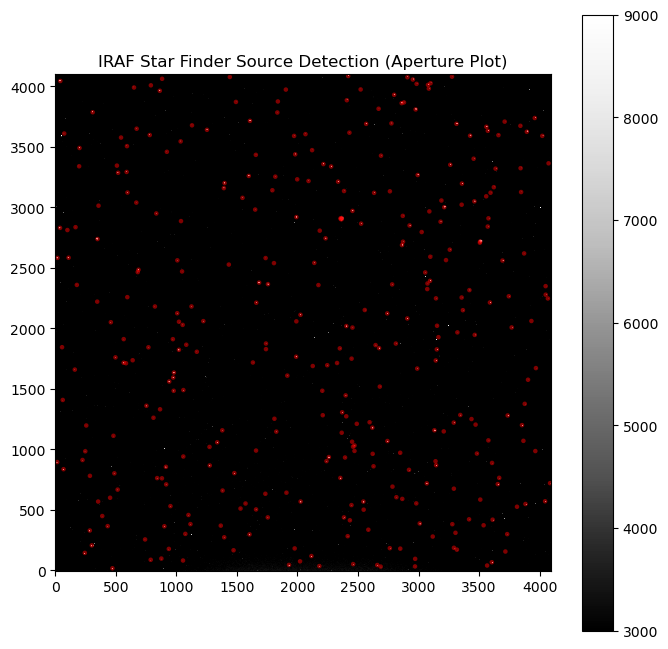

In [7]:
from photutils.aperture import CircularAperture
import numpy as np
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=10.)
plt.figure(figsize=(8,8))
plt.imshow(data, cmap='Greys_r', origin='lower', vmin=3000, vmax=9000, interpolation='nearest')
plt.colorbar()
plt.title("IRAF Star Finder Source Detection (Aperture Plot)")
apertures.plot(color='red', lw=1.5, alpha=0.5)

### Error estimation, including poisson error, for given image:

In [ ]:
from photutils.utils import calc_total_error

gain=0.242759602
error=calc_total_error(data-bkg.background, bkg.background_rms, gain)
print(np.median(error))
print(sources)
print(sources.colnames)

49.86628
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  471.9253869850101 ...   46238.5556640625 -11.662510649337603
  2  2686.790425508937 ... 22075.305419921875 -10.859766802285302
  3 2970.7315842965827 ...     4404.544921875  -9.109752609266218
  4 2180.7980010276983 ...  15182.02001953125   -10.4533238994142
  5 3566.1533392700994 ...  5005.826904296875  -9.248689570327727
  6  2658.886895206944 ...     16681.27734375 -10.555573257556198
  7 1930.0162173931808 ...   63153.6455078125  -12.00099606253441
  8  2460.025365666135 ...  10826.87353515625 -10.086257659925073
  9  3604.710431795118 ...   71923.8271484375  -12.14218197160526
 10 2021.4186139623425 ...    3058.7646484375  -8.713865155507577
...                ... ...                ...                 ...
341 3077.8002313354714 ...   65999.2548828125 -12.048847581199006
342    2983.7346676783 ...    15157.005859375 -10.451533546251534
3

### Photometry on all light frames in the processed directory:

In [ ]:
import glob
import os
from photutils.background import SExtractorBackground
from photutils.background import Background2D
from photutils.segmentation import detect_sources
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
#in function pass threshold multiplier... make the mask function....

def background(file:str) -> pht.background.Background2D:
    data = fits.getdata(file)
    mean, _, std = sigma_clipped_stats(data, sigma=3.0)
    segm = detect_sources(data-mean, 3*std, npixels=5)
    bool_array = segm.data != 0
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(data, (64, 64), mask=bool_array,filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    return bkg

#takes the output files from the data processing steps (located in the output directory) and globs into list, this serves as the input
def write_photometric_catalogues(light_frame_indicator:str, output_dir:str, threshold_multiplier:float):
    lights_processed=glob.glob(f'{output_dir}/*{light_frame_indicator}*')
    lights_processed.sort()
    radii=[3,4,5,6,8,10,12,15,20,25] ## aperture radii in pixels
    total=len(lights_processed)

    for i,file in enumerate(lights_processed):
        print(f"Aperture photometry on all objects: file {i+1}/{total}")
        # catfile='/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/'+'_cat.fits'
        rootname,_=os.path.splitext(file)
        print(rootname)
        catfile=f'/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/{i+1}-cat.fits' #TODO: clean up paths for io
        print(file)
        bkg = background(file)
        daofind = pht.detection.IRAFStarFinder(fwhm=3.0, threshold=threshold_multiplier*bkg.background_rms_median,exclude_border=True, sharplo=0.5, sharphi=2.0, roundlo=0.0, roundhi=0.7)
        sources = daofind(data - bkg.background) #rms or full bkg?
        positions = [(ix,iy) for ix,iy in zip(sources['xcentroid'],sources['ycentroid'])] #list of tuples representing position...
        apertures = [pht.aperture.CircularAperture(positions, r=r) for r in radii] #list of apertures, one for each of the radii given (10 total...)
        error = calc_total_error(data-bkg.background, bkg.background_rms, gain)
        #aper_phot is a dictionary object of all the sources past the threshold
        aper_phot = pht.aperture.aperture_photometry(data - bkg.background, apertures, error=error)
        print(len(aper_phot))
        aper_phot.write(catfile,overwrite=True)
        
#current constants
light_frame_indicator = "lrp"
threshold_multiplier = 15.
output_dir = '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output'



['/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_10.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_11.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_12.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_13.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_14.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_15.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_16.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_17.fit', '/Users/spencerfreeman/Desktop/Person

372
Aperture photometry on all objects: file 3/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_11
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_11.fit


377
Aperture photometry on all objects: file 4/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_12
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_12.fit


381
Aperture photometry on all objects: file 5/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_13
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_13.fit


388
Aperture photometry on all objects: file 6/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_14
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_14.fit


390
Aperture photometry on all objects: file 7/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_15
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_15.fit


393
Aperture photometry on all objects: file 8/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_16
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_16.fit


393
Aperture photometry on all objects: file 9/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_17
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_17.fit


394
Aperture photometry on all objects: file 10/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_18
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_18.fit


400
Aperture photometry on all objects: file 11/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_19
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_19.fit


404
Aperture photometry on all objects: file 12/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_2
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_2.fit


351
Aperture photometry on all objects: file 13/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_20
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_20.fit


407
Aperture photometry on all objects: file 14/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_21
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_21.fit


409
Aperture photometry on all objects: file 15/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_22
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_22.fit


413
Aperture photometry on all objects: file 16/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_23
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_23.fit


416
Aperture photometry on all objects: file 17/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_24
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_24.fit


421
Aperture photometry on all objects: file 18/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_25
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_25.fit


426
Aperture photometry on all objects: file 19/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_26
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_26.fit


428
Aperture photometry on all objects: file 20/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_27
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_27.fit


428
Aperture photometry on all objects: file 21/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_28
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_28.fit


430
Aperture photometry on all objects: file 22/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_29
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_29.fit


433
Aperture photometry on all objects: file 23/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_3
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_3.fit


351
Aperture photometry on all objects: file 24/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_30
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_30.fit


435
Aperture photometry on all objects: file 25/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_31
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_31.fit


438
Aperture photometry on all objects: file 26/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_32
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_32.fit


440
Aperture photometry on all objects: file 27/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_33
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_33.fit


450
Aperture photometry on all objects: file 28/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_34
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_34.fit


451
Aperture photometry on all objects: file 29/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_35
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_35.fit


454
Aperture photometry on all objects: file 30/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_36
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_36.fit


455
Aperture photometry on all objects: file 31/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_37
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_37.fit


456
Aperture photometry on all objects: file 32/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_38
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_38.fit


456
Aperture photometry on all objects: file 33/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_39
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_39.fit


457
Aperture photometry on all objects: file 34/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_4
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_4.fit


352
Aperture photometry on all objects: file 35/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_40
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_40.fit


459
Aperture photometry on all objects: file 36/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_41
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_41.fit


463
Aperture photometry on all objects: file 37/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_42
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_42.fit


462
Aperture photometry on all objects: file 38/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_43
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_43.fit


464
Aperture photometry on all objects: file 39/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_44.fit


465
Aperture photometry on all objects: file 40/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_5
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_5.fit


362
Aperture photometry on all objects: file 41/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_6
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_6.fit


362
Aperture photometry on all objects: file 42/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_7
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_7.fit


364
Aperture photometry on all objects: file 43/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_8
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_8.fit


367
Aperture photometry on all objects: file 44/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_9
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_9.fit


369


In [12]:
hdulist = fits.open('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/11-cat.fits')
bin_table_hdu = hdulist[1] 
# Access the table data
table_data = bin_table_hdu.data
print(table_data)

[(  1, 2914.62155721,   10.71430685,   43532.55980504,  490.44391864,   68886.09413135,  626.56512241,   97364.7813312 ,  755.71806   ,  128805.98612941,  880.5929254 ,  203862.32389382, 1129.19366861,  298437.01145309, 1381.86375627,  379112.69424395, 1618.06534353,   520689.15627471, 1932.21847447,   805115.26634628, 2422.63845982,  1149293.1456646 , 2898.29501768)
 (  2,  471.92538562,   17.90271187,  267194.45526385, 1078.76803706,  376390.27691101, 1289.42408703,  462575.9781363 , 1442.46895554,  528938.61398727, 1559.22171519,  632605.19080002, 1747.6835254 ,  728182.11941911, 1923.6126521 ,  832036.11082688, 2106.22990255,  1016592.71708664, 2400.6992524 ,  1339930.49256062, 2901.84673617,  1682170.64258653, 3351.06221762)
 (  3, 2686.79030888,   31.85893284,  132157.75606399,  778.83062136,  188957.09022478,  942.82087484,  239145.9052454 , 1076.02510145,  285277.22733768, 1193.25141014,  376480.73355391, 1411.72210473,  479108.72312937, 1632.2877786 ,  599919.19321261, 1861.68

### Take a look at two images side by side, to observe shifts qualatatively:

Text(0.5, 1.0, 'Exposure 40')

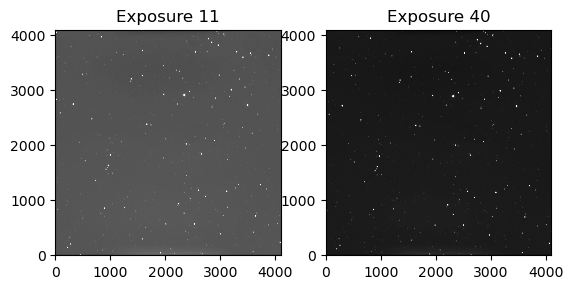

In [13]:
fig, axes = plt.subplots(1,2)
exposure = [11,40]
exposure1 = fits.getdata(f'/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_{exposure[0]}.fit')
exposure2 = fits.getdata(f'/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_{exposure[1]}.fit')

#could subtract background -bkg.background but thats not really the point
axes[0].imshow(exposure1, origin='lower', vmin=1500, vmax=5000, cmap='Greys_r')
axes[0].set_title(f"Exposure {exposure[0]}")
axes[1].imshow(exposure2, origin='lower', vmin=1500, vmax=5000, cmap='Greys_r')
axes[1].set_title(f"Exposure {exposure[1]}")


32.0 30.0


Text(0.5, 1.0, 'y shift')

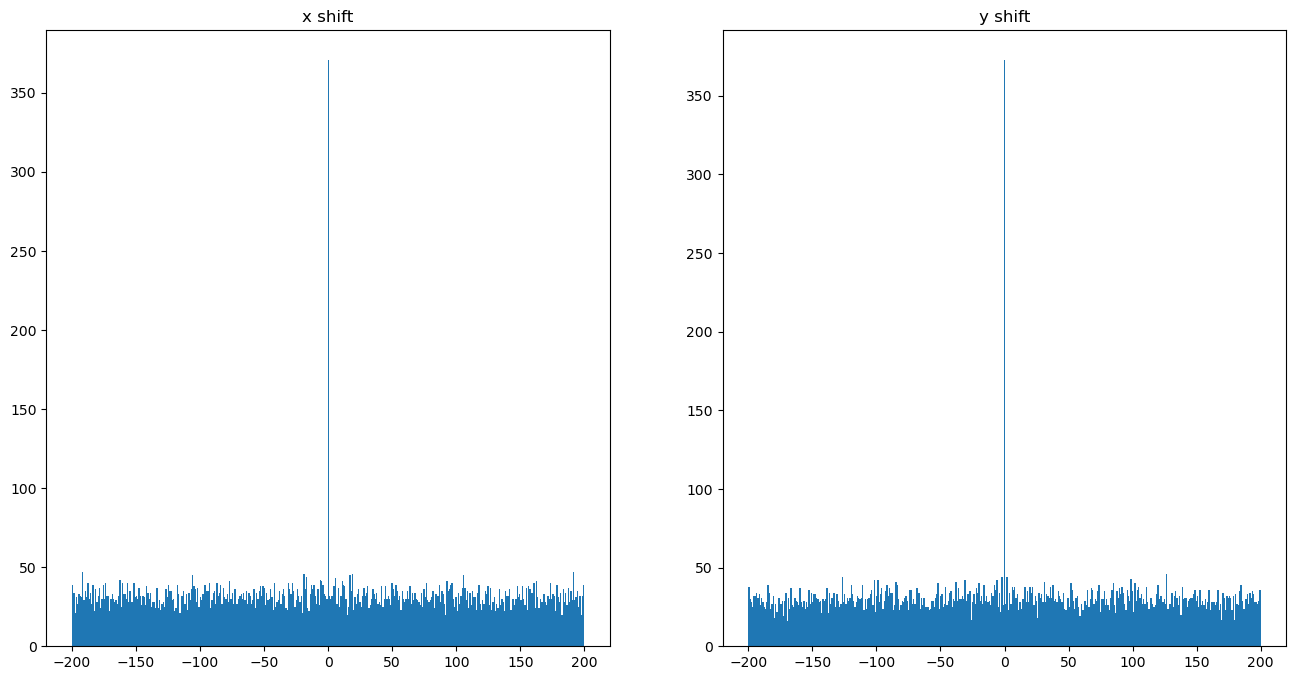

In [14]:
from astropy.table import Table

cat1 = Table.read('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/1-cat.fits')
cat2 = Table.read('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/2-cat.fits')
x1=cat1['xcenter']
y1=cat1['ycenter']
x2=cat2['xcenter']
y2=cat2['ycenter']

ncat1=len(cat1)
ncat2=len(cat2)
XX=[]
YY=[]

#calculate shift for each object in the catfile, denote this with XX for x shifts and YY for y shifts
#we have the form list - constant where the constant iterates throush all of the objects in the second image
#extend allows us to add another list (each shift) 
for i in range(ncat2):
    XX.extend((x1-x2[i]))
    YY.extend((y1-y2[i]))
 
XX=np.array(XX)
YY=np.array(YY)

xhist,xbins=np.histogram(XX,range=[-200,200],bins=401)
yhist,ybins=np.histogram(YY,range=[-200,200],bins=401)

print(np.median(xhist),np.median(yhist))

f,axs=plt.subplots(1,2,figsize=(16,8))
axs[0].hist(XX,range=[-200,200],bins=401)
axs[0].set_title("x shift")
axs[1].hist(YY,range=[-200,200],bins=401)
axs[1].set_title("y shift")

In [15]:
def calc_shifts_update_catalogues():
    catalogue_files = glob.glob('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/*cat.fits')
    catalogue_files.sort()
    #initial declarations:
    x1 = []; y1 = [] 
    reference_catalogue = Table.read(catalogue_files[0])
    
    for i,catalogue in enumerate(catalogue_files):
        #upon first iteration, set the reference catalogue to the first entry in the list of cat files
        if i==0:
            reference_catalogue = Table.read(catalogue)
            x1=reference_catalogue['xcenter']
            y1=reference_catalogue['ycenter']
            #add the xshift field if files have not been previously been processed.
            if 'x_shift' not in reference_catalogue.colnames:
                xcol=Table.Column(x1,name='x_shift')
                ycol=Table.Column(y1,name='y_shift')
                reference_catalogue.add_columns([xcol,ycol])
            else:
                reference_catalogue['x_shift']=x1
                reference_catalogue['y_shift']=y1
            reference_catalogue.write(catalogue,overwrite=True)
            print("Initial iteration complete, reference catalogue updated.")        
        else:
            catalogue_of_interest = Table.read(catalogue)
            n_catalogue_OI=len(catalogue_of_interest)
            x2=catalogue_of_interest['xcenter']
            y2=catalogue_of_interest['ycenter']
            XX = []
            YY = [] 
            for j in range(n_catalogue_OI):
                XX.extend((x1-x2[j]))
                YY.extend((y1-y2[j]))
            XX=np.array(XX)
            YY=np.array(YY)
            
            xhist,xbins=np.histogram(XX,range=[-200, 200],bins=400)
            yhist,ybins=np.histogram(YY,range=[-200, 200],bins=400)
            
            #find most common shift values and determine the x/y shift between frames
            idx=np.argmax(xhist)
            xshift_0=(xbins[idx]+xbins[idx+1])/2.0
            idx=np.argmax(yhist)
            yshift_0=(ybins[idx]+ybins[idx+1])/2.0
            print(f"Initial shift X (Iteration {i}): {xshift_0}, Initial Shift Y: {yshift_0}")
            
            #finetune shifts with masking techniques?
            mask=(np.abs(XX-xshift_0)<3) & (np.abs(YY-yshift_0)<3)
            print("Mask sum: ", mask.sum())
            xshift_finetuned=np.median(XX[mask])
            yshift_finetuned=np.median(YY[mask])
            print(f"Finetuned Shift (Iteration {i}): ", xshift_finetuned, yshift_finetuned)
            
            if 'x_shift' not in catalogue_of_interest.colnames:
                xcol=Table.Column(x2+xshift_finetuned,name='x_shift')
                ycol=Table.Column(y2+yshift_finetuned,name='y_shift')
                catalogue_of_interest.add_columns([xcol,ycol])
            else:
                #add the finetuned xshift to the x and y aperture columns in the catalogue.
                catalogue_of_interest['x_shift']=x2+xshift_finetuned
                catalogue_of_interest['y_shift']=y2+yshift_finetuned
            
            catalogue_of_interest.write(catalogue, overwrite=True)
            
calc_shifts_update_catalogues()

Initial iteration complete, reference catalogue updated.
Initial shift X (Iteration 1): 0.5, Initial Shift Y: 0.5
Mask sum:  350
Finetuned Shift (Iteration 1):  0.0 0.0
Initial shift X (Iteration 2): -0.5, Initial Shift Y: 0.5
Mask sum:  350
Finetuned Shift (Iteration 2):  -3.509972543724871e-07 7.122287115635118e-07
Initial shift X (Iteration 3): 0.5, Initial Shift Y: 0.5
Mask sum:  350
Finetuned Shift (Iteration 3):  1.3963449418952223e-07 1.3292449985158328e-06
Initial shift X (Iteration 4): -0.5, Initial Shift Y: -0.5
Mask sum:  350
Finetuned Shift (Iteration 4):  -3.512627699819859e-08 -2.1069195099698845e-07
Initial shift X (Iteration 5): 0.5, Initial Shift Y: 0.5
Mask sum:  350
Finetuned Shift (Iteration 5):  6.7045118612441e-07 2.8034049819325446e-06
Initial shift X (Iteration 6): -0.5, Initial Shift Y: 0.5
Mask sum:  350
Finetuned Shift (Iteration 6):  -2.8767507842530904e-07 1.4069846656639129e-06
Initial shift X (Iteration 7): -0.5, Initial Shift Y: 0.5
Mask sum:  350
Finetu

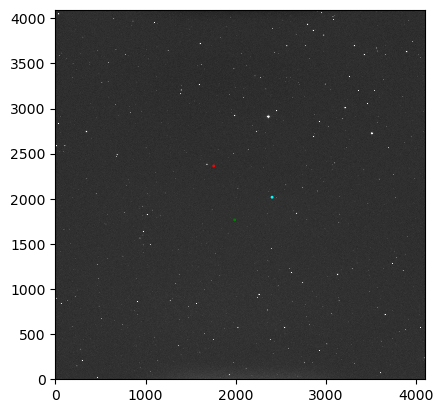

In [ ]:
hdu_list = fits.open('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1.fit')
data = hdu_list[0].data

x_targ,y_targ = (2403.662364756954, 2018.2046627353204)
x_comp,y_comp = (1756.1089736736467, 2364.1375110432928)
x_vali,y_vali = (1988.9627767690627, 1765.0694999895554)

aper_targ = CircularAperture((x_targ,y_targ), r=8.)
aper_comp = CircularAperture((x_comp,y_comp), r=8.)
aper_vali = CircularAperture((x_vali,y_vali), r=8.)

aper_targ.plot(color='cyan')
aper_comp.plot(color='red')
aper_vali.plot(color='green')
plt.imshow(data, origin='lower', cmap='Greys_r', vmin=1500, vmax=10000, interpolation='nearest')

In [94]:
def find_nearest_pair(qtable, x_col:str, y_col:str, target_x:float, target_y:float) -> tuple[float, float]:
    """Finds the (x, y) pair in a QTable that is closest to a given point.

    Args:
        qtable (astropy.table.QTable): The QTable to search.
        x_col (str): The name of the column containing x-coordinates.
        y_col (str): The name of the column containing y-coordinates.
        target_x (float): The x-coordinate of the target point.
        target_y (float): The y-coordinate of the target point.

    Returns:
        tuple: The (x, y) pair from the QTable that is closest to the target point.
    """

    x = qtable[x_col]
    y = qtable[y_col]
    distances = np.sqrt((x - target_x)**2 + (y - target_y)**2)
    min_index = np.argmin(distances)

    return qtable[x_col][min_index], qtable[y_col][min_index]

cat1 = Table.read('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/1-cat.fits')
print(cat1)
find_nearest_pair(cat1, 'xcenter', 'ycenter', x_targ, y_targ)
find_nearest_pair(cat1, 'xcenter', 'ycenter', x_comp, y_comp)
find_nearest_pair(cat1, 'xcenter', 'ycenter', x_vali, y_vali)

 id      xcenter       ...      x_shift            y_shift      
           pix         ...        pix                pix        
--- ------------------ ... ------------------ ------------------
  1  471.9253909664649 ...  471.9253909664649  17.90271571564873
  2 2686.7904049963195 ... 2686.7904049963195  31.85888815714706
  3 2970.7317758561885 ... 2970.7317758561885  33.21563365408658
  4  2180.798024982387 ...  2180.798024982387  36.18901546808961
  5  3566.153311790268 ...  3566.153311790268 40.737274950514646
  6 2658.8868744476245 ... 2658.8868744476245 44.700330236568774
  7 1930.0162164062892 ... 1930.0162164062892 45.739066461837965
  8 2460.0253990891547 ... 2460.0253990891547  51.98687432571979
  9 3604.7104293818466 ... 3604.7104293818466  67.79795896246725
...                ... ...                ...                ...
341 3077.8002088980074 ... 3077.8002088980074   4009.87268682966
342  2983.734587030014 ...  2983.734587030014 4018.1874432020218
343  3098.931043932521 ..

(1988.9627715305342, 1765.0695191800708)

Text(0.5, 1.0, 'Testing Target, Comparison, and Validation Apertures \nr=8.0 pix')

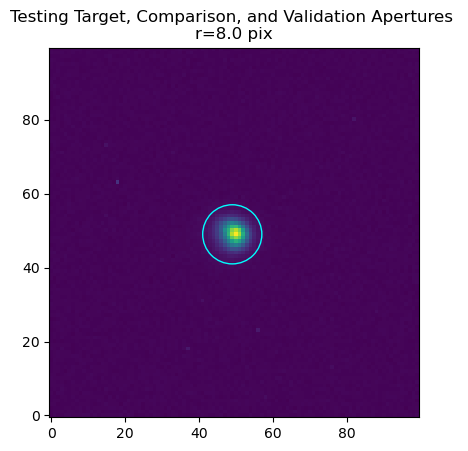

In [ ]:
from astropy.nddata import Cutout2D
x_targ,y_targ = (2403.662364756954, 2018.2046627353204)
x_comp,y_comp = (1756.1089736736467, 2364.1375110432928)
x_vali,y_vali = (1988.9627767690627, 1765.0694999895554)
cutout = Cutout2D(data, (x_vali,y_vali), (100, 100))
aper_targ = CircularAperture((49,49), r=8.)
aper_targ.plot(color='cyan')
plt.imshow(cutout.data, origin='lower')
plt.title("Testing Target, Comparison, and Validation Apertures \nr=8.0 pix")

### Function to grab the date from the processed light, and chage the format to JD 

In [18]:
from astropy.time import Time

header_lc = fits.getheader('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1.fit')

def iso_date_to_JD(iso_date:str) -> str:
    iso_date = iso_date.replace("T", " ")
    t = Time(iso_date, format='iso')
    return t.jd

print(iso_date_to_JD(header_lc['DATE-OBS']))

2460558.623234491


In [ ]:
from astropy.time import Time
import glob

def iso_date_to_JD(iso_date:str) -> float:
    iso_date = iso_date.replace("T", " ")
    t = Time(iso_date, format='iso')
    return t.jd

def calculate_light_curves(output_directory:str, cat_indicator:str, n_radii:int, target_location:tuple, comparison_location:tuple, validation_location:tuple) -> tuple[list, list, list]:
    catalogue_files = glob.glob(output_directory + f'*{cat_indicator}*')
    processed_light_files = glob.glob(output_directory + '*lrp*')
    
    catalogue_files.sort()
    processed_light_files.sort()
    
    n_files = len(catalogue_files)
    n_time_stamps = len(processed_light_files)
    # if(n_files!=n_time_stamps):
    #     raise Exception("ERROR: Output light files list differs in length from output catalogue file list. \n --> Check to ensure that no files were moved or deleted.")
    target_lc=np.zeros((1+2*n_radii,n_files))
    comparison_lc=np.zeros((1+2*n_radii,n_files))
    validation_lc=np.zeros((1+2*n_radii,n_files))
    
    print("Calcluating target, comparison, and validation light curves.")
    
    '''first we get the time (JD) from the paralell list of light files, then sum the apertures'''
    
    for i, file in enumerate(catalogue_files):
        header = fits.getheader(processed_light_files[i])
        datestr = iso_date_to_JD(header['DATE-OBS'])

        target_lc[0,i] = datestr
        comparison_lc[0,i] = datestr
        validation_lc[0,i] = datestr
        
        catalogue = fits.getdata(file)
        
        x_source_locations = catalogue['x_shift']
        y_source_locations = catalogue['y_shift']
        
        #This is pretty inefficent but perhaps more efficent than using a star database, solving, and converting?
        target_distance_array = np.sqrt((x_source_locations - target_location[0])**2+(y_source_locations - target_location[1])**2)
        minimum_index = np.argmin(target_distance_array)
        #TODO: use a tolerance, assume correct FOR NOW
        distance_undertainty = target_distance_array[minimum_index]
        target_aper_arr = catalogue[minimum_index]
        #add the aperture sums to the first half of the array and their repective errors to the second half of the target lightcurve array
        for j in range(n_radii):
            target_lc[j+1,i]=target_aper_arr['aperture_sum_'+str(j)]
            target_lc[n_radii+j+1,i]=target_aper_arr['aperture_sum_err_'+str(j)]
        
        #repeat the process for the comparison star:
        comparison_distance_array = np.sqrt((x_source_locations - comparison_location[0])**2+(y_source_locations - comparison_location[1])**2)
        minimum_index_comp = np.argmin(comparison_distance_array)
        distance_undertainty = catalogue[minimum_index]
        comparison_aper_arr = catalogue[minimum_index_comp]
        for j in range(n_radii):
            comparison_lc[j+1,i]=comparison_aper_arr['aperture_sum_'+str(j)]
            comparison_lc[n_radii+j+1,i]=comparison_aper_arr['aperture_sum_err_'+str(j)]
        
        #and again for the validation star:
        validation_distance_array = np.sqrt((x_source_locations - validation_location[0])**2+(y_source_locations - validation_location[1])**2)
        minimum_index_vali = np.argmin(validation_distance_array)
        distance_undertainty = catalogue[minimum_index_vali]
        validation_aper_arr = catalogue[minimum_index_vali]
        for j in range(n_radii):
            validation_lc[j+1,i]=validation_aper_arr['aperture_sum_'+str(j)]
            validation_lc[n_radii+j+1,i]=validation_aper_arr['aperture_sum_err_'+str(j)]
        
    return (target_lc, comparison_lc, validation_lc)

target_lc, comparison_lc, validation_lc = calculate_light_curves('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/', 'cat', n_radii=10, target_location=(2403.66, 2018.20), comparison_location=(1756.11, 2364.13), validation_location=(1988.96, 1765.06))
    

Calcluating targer, comparison, and validation light curves.


In [93]:
print(comparison_lc[6+1,:], validation_lc[6+1,:])

[ 945132.56867717  945132.56867717 1230433.49904193 1242022.00572387
  963334.94299843 1259634.02670943 1277789.23704644 1284871.80883294
 1296376.44457135 1305717.73236539 1314935.23777579 1321343.8639638
 1122586.60258971 1325893.40491289 1329216.26141846 1341280.50532717
  962552.38444542 1348138.52987588 1349781.65001604 1357673.29000411
 1366917.10700617 1382202.79044164 1386616.57986105 1135835.26995558
 1388870.5251456  1392466.1466805  1396114.84466686 1400770.79971265
  969898.21484764 1405415.29561726 1412171.19216789 1414699.72112993
 1415434.60546851 1420054.62306708 1149438.58736037 1009392.18603583
 1042126.56332542 1067988.62119736 1086332.9548812  1167689.38958301
 1175540.82051356 1187018.18233377 1201405.51810885 1215111.45438017] [ 945132.56867717  945132.56867717 1230433.49904193 1242022.00572387
  963334.94299843 1259634.02670943 1277789.23704644 1284871.80883294
 1296376.44457135 1305717.73236539 1314935.23777579 1321343.8639638
 1122586.60258971 1325893.40491289 

[ 945132.56867717  945132.56867717 1230433.49904193 1242022.00572387
  963334.94299843 1259634.02670943 1277789.23704644 1284871.80883294
 1296376.44457135 1305717.73236539 1314935.23777579 1321343.8639638
 1122586.60258971 1325893.40491289 1329216.26141846 1341280.50532717
  962552.38444542 1348138.52987588 1349781.65001604 1357673.29000411
 1366917.10700617 1382202.79044164 1386616.57986105 1135835.26995558
 1388870.5251456  1392466.1466805  1396114.84466686 1400770.79971265
  969898.21484764 1405415.29561726 1412171.19216789 1414699.72112993
 1415434.60546851 1420054.62306708 1149438.58736037 1009392.18603583
 1042126.56332542 1067988.62119736 1086332.9548812  1167689.38958301
 1175540.82051356 1187018.18233377 1201405.51810885 1215111.45438017]
photerr for target/comparison: 0.002713514933868854
photerr for validation/comparison: 0.002700845301686793
(0.0, 0.0, 0.0)


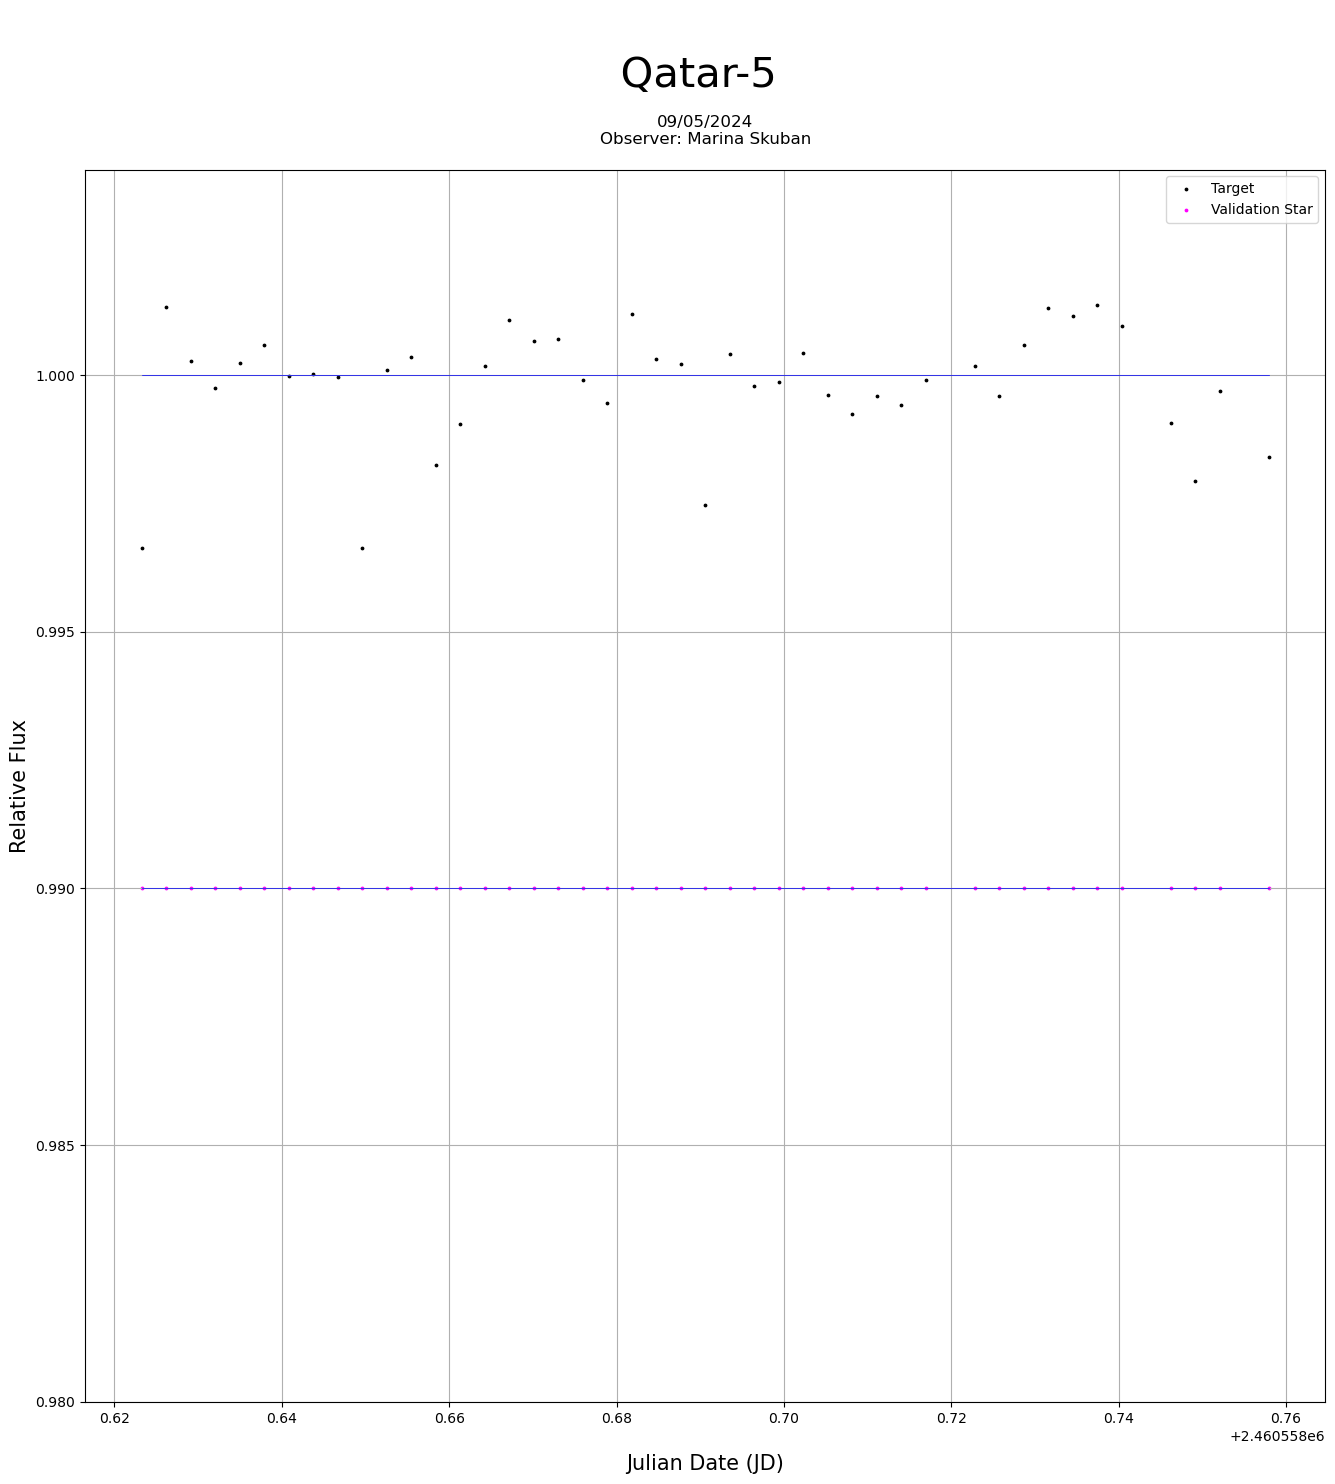

In [97]:
def get_plotting_data(target_lc:list, comparison_lc:list, validation_lc:list, iaper:int) -> tuple[list, list, float, float, float, float, list]:
    iaper=6 # for iaper aperture
    lc_target_plot=target_lc[iaper+1,:]/comparison_lc[iaper+1,:]
    lc_validation_plot=validation_lc[iaper+1,:]/comparison_lc[iaper+1,:]
    a1=1.0/comparison_lc[iaper+1,:]; e1=target_lc[iaper+10+1,:]
    a2=target_lc[iaper+1,:]/comparison_lc[iaper+1,:]**2; e2=comparison_lc[iaper+10+1,:]
    error_target=np.sqrt(a1**2*e1**2+a2**2*e2**2)

    print(validation_lc[iaper+1, :])

    a1=1.0/comparison_lc[iaper+1,:]; e1=validation_lc[iaper+10+1,:]
    a2=validation_lc[iaper+1,:]/comparison_lc[iaper+1,:]**2; e2=comparison_lc[iaper+10+1,:]
    error_valiation=np.sqrt(a1**2*e1**2+a2**2*e2**2)
    print('photerr for target/comparison:',np.median(error_target))
    print('photerr for validation/comparison:',np.median(error_valiation))
    idx=np.argmin(np.abs(target_lc[0,:]-51888.67))
    norm_targ=np.median(lc_target_plot[idx:])
    norm_vali=np.median(lc_validation_plot[idx:])
    time_axis_range=[np.min(target_lc[0,:]),np.max(target_lc[0,:])]
    return lc_target_plot, lc_validation_plot, error_target, error_valiation, norm_targ, norm_vali, time_axis_range

###plotting###
transit_name = "Qatar-5"
date = "09/05/2024"
observer_name = "Marina Skuban"

def plot_light_curve(jd:list, lc_target_plot:list, lc_validation_plot:list, norm_targ:float, norm_vali:float, time_axis_range:list, directory_out:str, transit_name:str, date:str, observer_name:str):
    plt.figure(figsize=(16,16))
    plt.scatter(jd[0,:],lc_target_plot/norm_targ,color='black', marker='o',s=3,label="Target")
    plt.scatter(jd[0,:],lc_validation_plot/norm_vali-0.01,color='magenta', marker='o',s=3, label="Validation Star")
    plt.plot(time_axis_range,[1.0,1.0],'b-',linewidth=.5)
    plt.plot(time_axis_range,[.990,.990],'b-',linewidth=.5)
    plt.ylim([0.980,1.004])
    plt.xlabel("\nJulian Date (JD)",fontsize=15)
    plt.ylabel("Relative Flux", fontsize=15)
    plt.grid(True)
    plt.suptitle(f"\n  {transit_name}", fontsize=30)
    plt.title(f"{date}\nObserver: {observer_name}\n", fontsize=12)
    plt.legend()
    plt.savefig(directory_out+f"/{transit_name}")
    print(sigma_clipped_stats(2.5*np.log10(lc_validation_plot),sigma=3,maxiters=3))

lc_target_plot, lc_validation_plot, error_target, error_valiation, norm_targ, norm_vali, time_axis_range = get_plotting_data(target_lc, comparison_lc, validation_lc, 6)
plot_light_curve(target_lc, lc_target_plot, lc_validation_plot, norm_targ, norm_vali, time_axis_range, "/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output", transit_name, date, observer_name)